<a href="https://colab.research.google.com/github/sagurjar027/Hate_speech_detection-NLP-project/blob/main/hate_specch_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  ## Hate Speech Detection

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import spacy
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
# 1. DELETING UNWANTED COLUMNS
data.drop(columns = ['Unnamed: 0',	'count',	'hate_speech',	'offensive_language',	'neither'],
        inplace = True)

In [6]:
data.isnull().sum()

,0
class,0
tweet,0


In [7]:
# Clean text: remove non-alphabetic characters
data['clean_text'] = data['tweet'].str.replace(r'[^a-zA-Z]', ' ', regex=True)
data['clean_text'] = data['clean_text'].str.replace(r'\s+', ' ', regex=True)


In [8]:
# Load only the lemmatizer from spaCy (disabling parser, NER, etc.)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat", "tagger"])

# Faster batch processing with nlp.pipe
def lemmatization(texts):
    return [' '.join([token.lemma_ for token in doc]) for doc in nlp.pipe(texts, batch_size=50)]

data['lemmatized'] = lemmatization(data['clean_text'])


/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [9]:
data.head()

,class,tweet,clean_text,lemmatized
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,RT mayasolovely As a woman you shouldn t comp...,rt mayasolovely as a woman you shouldn t com...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,RT mleew boy dats cold tyga dwn bad for cuffi...,rt mleew boy dats cold tyga dwn bad for cuff...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,RT UrKindOfBrand Dawg RT sbaby life You ever ...,rt urkindofbrand dawg rt sbaby life you ever...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,RT C G Anderson viva based she look like a tr...,rt c g anderson viva based she look like a t...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,RT ShenikaRoberts The shit you hear about me ...,rt shenikaroberts the shit you hear about me...


In [10]:

def remove_stopwords(texts):
    return [
        ' '.join([token.text for token in doc if not token.is_stop])
        for doc in nlp.pipe(texts, batch_size=50)
    ]

data['processed_text'] = remove_stopwords(data['lemmatized'])


/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [11]:
vocab_size = 10000
encoded_docs = [one_hot(text,vocab_size) for text in data['processed_text']]

In [12]:
max_len = 20
padding_docs = pad_sequences(encoded_docs,maxlen=max_len,padding='pre')

In [13]:
X = np.array(padding_docs)
y = data['class'].values

In [17]:
smote = SMOTE(sampling_strategy='minority',random_state=42)
X_bal , y_bal = smote.fit_resample(X,y)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)

In [20]:
embedding_dim = 50
model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    layers.LSTM(100,return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(50,return_sequences=True),
    layers.LSTM(50),
    layers.Dense(3,activation='softmax')
])


model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.fit(X_train,y_train,epochs=10,batch_size = 32,validation_split=0.1)

Epoch 1/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 80s 76ms/step - accuracy: 0.7493 - loss: 0.5505 - val_accuracy: 0.9145 - val_loss: 0.2492
Epoch 2/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 62s 55ms/step - accuracy: 0.9418 - loss: 0.1785 - val_accuracy: 0.9216 - val_loss: 0.2342
Epoch 3/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - accuracy: 0.9650 - loss: 0.1208 - val_accuracy: 0.9177 - val_loss: 0.2873
Epoch 4/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 53s 55ms/step - accuracy: 0.9733 - loss: 0.0916 - val_accuracy: 0.9066 - val_loss: 0.3120
Epoch 5/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 89s 63ms/step - accuracy: 0.9805 - loss: 0.0674 - val_accuracy: 0.9025 - val_loss: 0.3884
Epoch 6/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 75s 56ms/step - accuracy: 0.9838 - loss: 0.0534 - val_accuracy: 0.8892 - val_loss: 0.4141
Epoch 7/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 80s 53ms/step - accuracy: 0.9891 - loss: 0.0342 - val_accuracy: 0.8939 - val_loss: 0.5190
Epoch 8/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 83s 54ms/step - accuracy: 0.9936 - loss: 0.0218 - 

In [23]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
loss_train, accuracy_train = model.evaluate(X_train, y_train)
print(f"Train Loss: {loss_train:.4f}, Train Accuracy: {accuracy_train:.4f}")

y_pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_test, y_pred))

266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8828 - loss: 0.6249
Test Loss: 0.6313, Test Accuracy: 0.8818
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9945 - loss: 0.0201
Train Loss: 0.0797, Train Accuracy: 0.9835
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      3838
           1       0.89      0.91      0.90      3838
           2       0.78      0.57      0.66       833

    accuracy                           0.88      8509
   macro avg       0.85      0.80      0.82      8509
weighted avg       0.88      0.88      0.88      8509



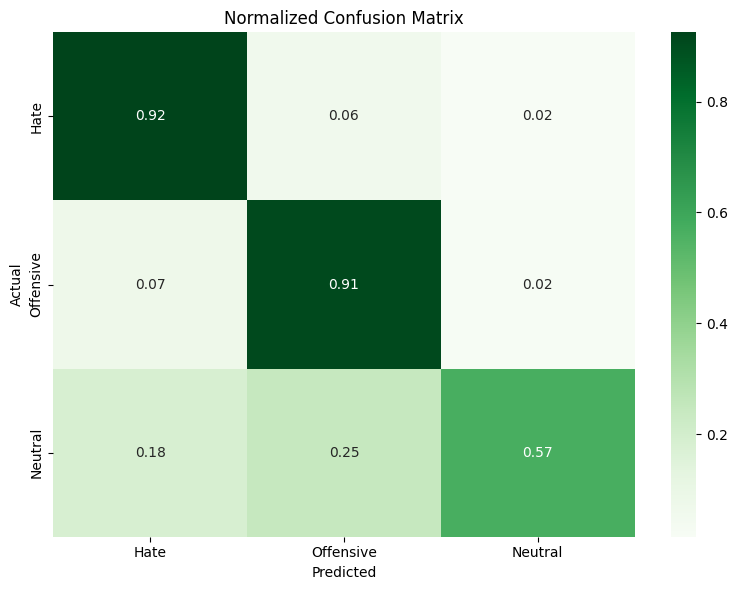

In [29]:
# Confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Greens', fmt=".2f", xticklabels=["Hate", "Offensive", "Neutral"], yticklabels=["Hate", "Offensive", "Neutral"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()